### Prepare data

In [1]:
library(sqldf)
library(ggplot2)

Loading required package: gsubfn
Loading required package: proto
Loading required package: RSQLite


Download csv data from github

In [2]:
airq25<-read.csv("https://raw.githubusercontent.com/Maplub/AirQualityData/master/PM2-5_2018_Daily.csv")
airq10<-read.csv("https://raw.githubusercontent.com/Maplub/AirQualityData/master/PM10_2018_Daily.csv")

Change column names

In [3]:
colnames(airq25)<-c("id","da","pm25")
colnames(airq10)<-c("id","da","pm10")

Join PM2.5 and PM10 Table

In [4]:
airq<-sqldf("select a.id,a.da,a.pm25,b.pm10 from airq25 a, airq10 b where a.id=b.id and a.da=b.da")

Loading required package: tcltk
Warning message:
“Quoted identifiers should have class SQL, use DBI::SQL() if the caller performs the quoting.”

There is one SOO94 (O not 0) row. Just remove it

In [5]:
airq<-airq[!grepl("CU-SOO94", airq$id),]

Read sensorlist from file. Set to UTF-8.

In [6]:
sensorlist<-read.csv("sensorlist.csv",encoding="UTF-8", stringsAsFactors=FALSE)
sensorlist[]     <- lapply(sensorlist, as.character)
Encoding(sensorlist$tambol)

[1] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[10] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[19] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[28] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[37] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[46] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[55] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[64] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[73] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[82] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[91] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"

Change da column to Date format

In [7]:
airq$date<-as.Date(airq$da,"%d-%m-%Y")

To use code from the previous year, separate day, month, and year.

In [8]:
library(stringr)
airq$d<-str_split_fixed(airq$da, "-", 3)[,1]
airq$m<-str_split_fixed(airq$da, "-", 3)[,2]
airq$y<-str_split_fixed(airq$da, "-", 3)[,3]

Change d,m,y to numeric

In [9]:
airq$m<-as.numeric(airq$m)
airq$d<-as.numeric(airq$d)
airq$y<-as.numeric(airq$y)

Calculate day of year

In [10]:
airq$doy <- strftime(airq$date, format = "%j")
airq$doy<-as.numeric(airq$doy)

Remove NA rows.

In [11]:
airq<-na.omit(airq)

Give the label to month, save it as monthf

In [12]:
airq$monthf<-factor(airq$m,levels=as.character(1:12),labels=c("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"),ordered=TRUE)

Get week of year from date

In [13]:
airq$woy<-as.numeric(format(airq$date,"%W"))

Below is the code from the previous year. I forget what it is.

In [14]:
library(plyr)
airq<-ddply(airq,.(m),transform,monthweek=1+woy-min(woy))

In [15]:
airq$dow<-as.POSIXlt(airq$date)$wday

In [16]:
airq$dowf<-factor(airq$dow,levels=rev(0:6),labels=rev(c("Sun","Mon","Tue","Wed","Thu","Fri","Sat")),ordered=TRUE)

In [17]:
airqdaily<-sqldf('select date,y,monthf,monthweek,dowf,avg(pm25) from airq group by y,doy')
colnames(airqdaily)[6]<-"avgpm25"
maxpm25<-max(airqdaily$avgpm25)
airqdaily$pm25f<-cut(airqdaily$avgpm25,c(0, 15, 40, 65, 150,maxpm25))

In [18]:
sqldf('select distinct(pm25f) from airqdaily')

pm25f
"(40,65]"
"(65,116]"
"(15,40]"
"(0,15]"


### And finally! I can plot it.

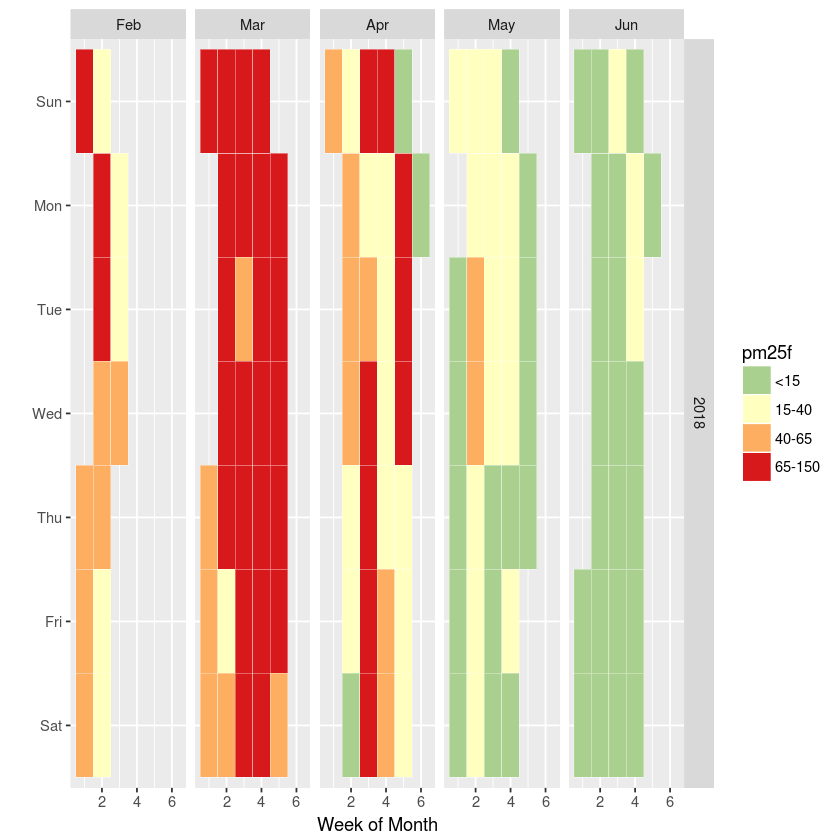

In [19]:
ggplot(airqdaily, aes(monthweek,dowf)) + geom_tile(aes(fill = pm25f),colour = "white") + scale_fill_manual(values=c("#A9D08E","#ffffbf","#fdae61","#d7191c","#54278f"),labels = c("<15","15-40","40-65","65-150",">150"))+ facet_grid(y~monthf) + xlab("Week of Month") + ylab("")

In [20]:
airqdaily<-sqldf('select date,y,monthf,monthweek,dowf,avg(pm10) from airq group by y,doy')
colnames(airqdaily)[6]<-"avgpm10"
maxpm10<-max(airqdaily$avgpm10)
airqdaily$pm10<-cut(airqdaily$avgpm10,c(0,50,100,200,300,maxpm10))

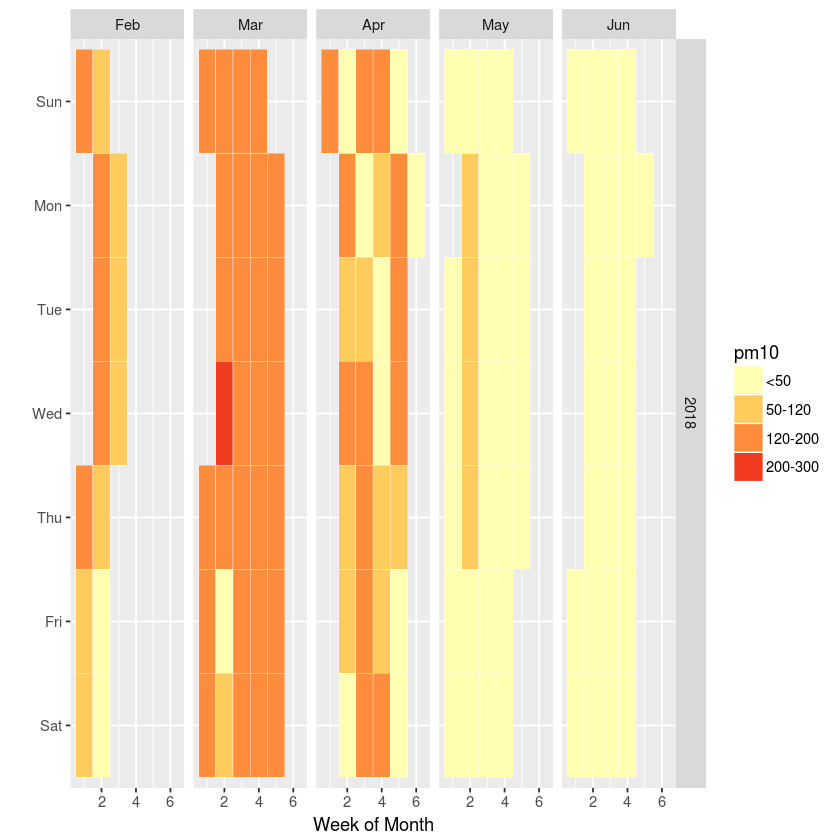

In [21]:
ggplot(airqdaily, aes(monthweek,dowf)) + geom_tile(aes(fill = pm10),colour = "white") + scale_fill_manual(values=c("#ffffb2","#fecc5c","#fd8d3c","#f03b20","grey"),labels = c("<50","50-120","120-200","200-300",">300"))+ facet_grid(y~monthf) + xlab("Week of Month") + ylab("")

Bind it with sensorlist to get Tambol name

In [22]:
airq<-sqldf("select a.*,s.tambol,s.amphoe from airq a, sensorlist s where a.id=s.sensorid")

In [23]:
maxpm25<-max(airq$pm10)
maxpm10<-max(airq$pm10)
airq$pm25cat<-cut(airq$pm25,c(0, 15, 40, 65, 150,maxpm25))
airq$pm10cat<-cut(airq$pm10,c(0,50,100,200,300,maxpm10))

In [24]:
head(airq)

id,da,pm25,pm10,date,d,m,y,doy,monthf,woy,monthweek,dow,dowf,tambol,amphoe,pm25cat,pm10cat
CU-S0001,28-02-2018,52.52500,102.73000,2018-02-28,28,2,2018,59,Feb,9,3,3,Wed,บ่อเกลือเหนือ,บ่อเกลือ,"(40,65]","(100,200]"
CU-S0002,15-02-2018,62.89826,123.37442,2018-02-15,15,2,2018,46,Feb,7,1,4,Thu,บ่อแก้ว,นาหมื่น,"(40,65]","(100,200]"
CU-S0002,16-02-2018,50.96376,96.69993,2018-02-16,16,2,2018,47,Feb,7,1,5,Fri,บ่อแก้ว,นาหมื่น,"(40,65]","(50,100]"
CU-S0002,17-02-2018,77.15833,143.26000,2018-02-17,17,2,2018,48,Feb,7,1,6,Sat,บ่อแก้ว,นาหมื่น,"(65,150]","(100,200]"
CU-S0002,18-02-2018,79.91827,141.49231,2018-02-18,18,2,2018,49,Feb,7,1,0,Sun,บ่อแก้ว,นาหมื่น,"(65,150]","(100,200]"
CU-S0002,19-02-2018,72.95452,133.82766,2018-02-19,19,2,2018,50,Feb,8,2,1,Mon,บ่อแก้ว,นาหมื่น,"(65,150]","(100,200]"


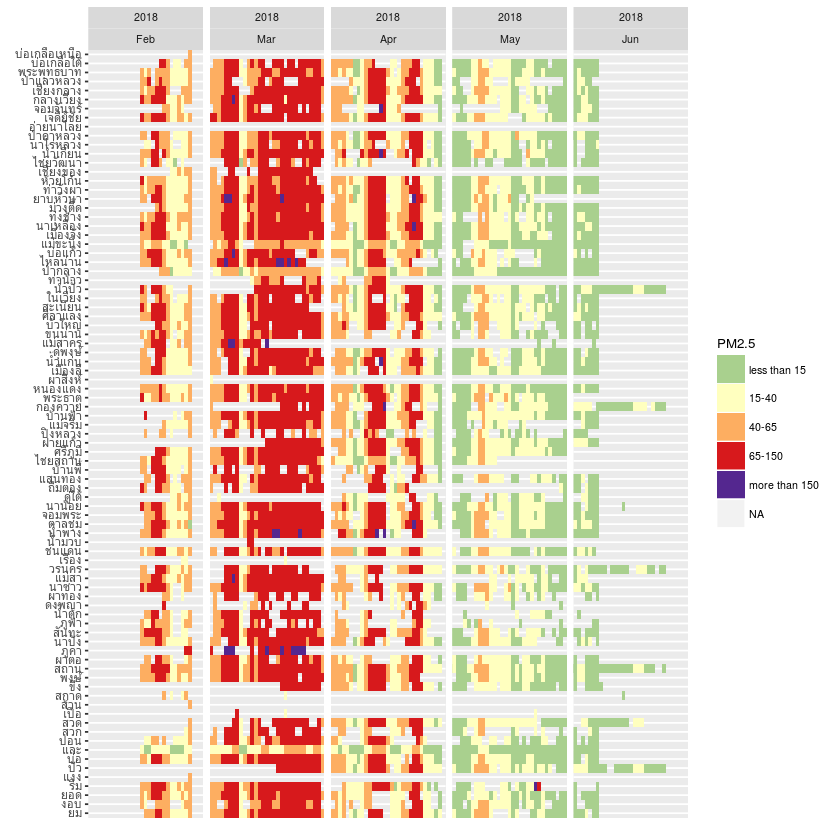

In [25]:
p<-ggplot(airq, aes(d,tambol)) +geom_tile(aes(fill = pm25cat))+facet_grid(.~ y+monthf)+ scale_fill_manual(guide = guide_legend(title = "PM2.5"),values=c("#A9D08E","#ffffbf","#fdae61","#d7191c","#54278f"),labels = c("less than 15","15-40","40-65","65-150","more than 150"))
base_size<-8
p +theme_grey(base_size = base_size) + labs(x = "",y = "") + scale_x_discrete(expand = c(0, 0)) +
scale_y_discrete(expand = c(0, 0))

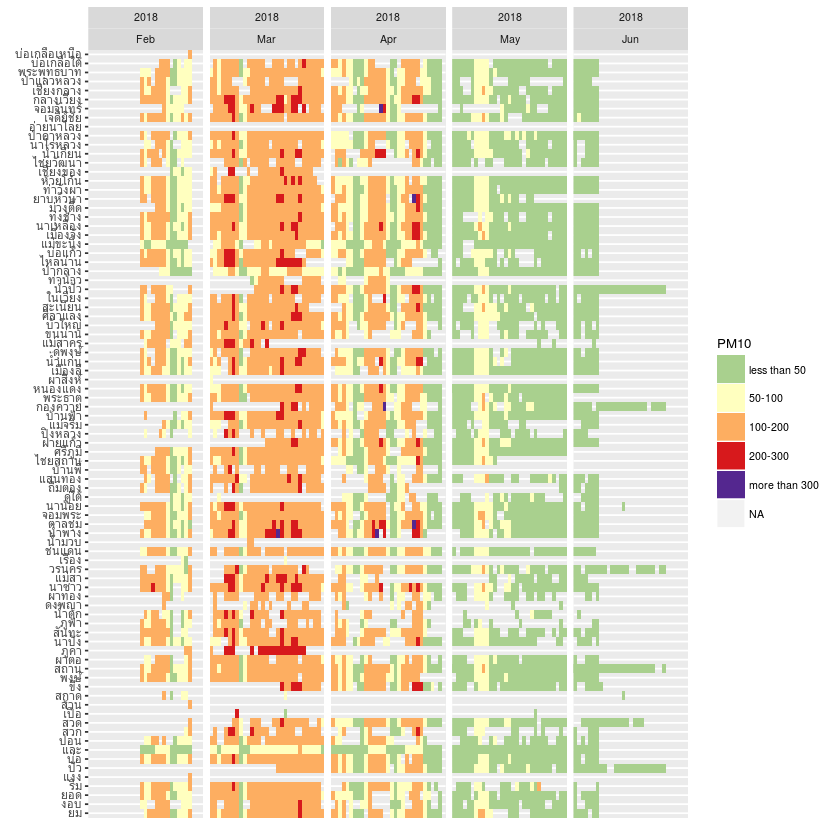

In [26]:
p<-ggplot(airq, aes(d,tambol)) +geom_tile(aes(fill = pm10cat))+facet_grid(.~ y+monthf)+ scale_fill_manual(guide = guide_legend(title = "PM10"),values=c("#A9D08E","#ffffbf","#fdae61","#d7191c","#54278f"),labels = c("less than 50","50-100","100-200","200-300","more than 300"))
base_size<-8
p +theme_grey(base_size = base_size) + labs(x = "",y = "") + scale_x_discrete(expand = c(0, 0)) +
scale_y_discrete(expand = c(0, 0))